Correct for dust extinction due to both Galactic dust and the extinction within the galaxy (should be a function of inclination).

In [12]:
import numpy as np

from astropy.table import Table
from astropy.io import fits

import time

import matplotlib.pyplot as plt

# Data

## Galaxies

In [2]:
gals_directory = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/'

gals_filename = 'SGA-2020_fuji_Vrot_photsys.fits'

gals = Table.read(gals_directory + gals_filename)

In [7]:
len(gals)

1164

In [3]:
targets_directory = '/global/cfs/projectdirs/desi/science/td/pv/'

targets_filename = 'desi_pv_tf_fuji_healpix.fits'

targets = Table.read(targets_directory + targets_filename)

In [6]:
len(targets)

13134

In [4]:
fastspecfit_directory = '/global/cfs/cdirs/desi/public/edr/vac/edr/fastspecfit/fuji/v3.2/'

# Dust extinction

Ratios of total to selective extinction (rederived from Schlafly11 and listed on https://www.legacysurvey.org/dr10/catalogs/#galactic-extinction-coefficients)

In [5]:
Rr = 2.165
Rv = 3.1 # from Schlafly & Finkbeiner (2011) - https://ui.adsabs.harvard.edu/abs/2011ApJ...737..103S/abstract

## 1. Extract line fluxes

We need to identify which spectra were actually used in the analysis, so that we can use "good" flux estimates.

In [ ]:
'''
################################################################################
# Separate the data into center and off-center observations
#-------------------------------------------------------------------------------
targets['SKY_FIBER_DIST'] = 0.
targets['SKY_FIBER_DIST_R26'] = 0.
targets['V_ROT'] = np.nan
targets['V_ROT_ERR'] = np.nan


for i in range(len(gals)):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = targets['SGA_ID'] == gals['SGA_ID'][i]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the galaxy
    #---------------------------------------------------------------------------
    gal_coords = SkyCoord(ra=gals['RA'][i], 
                          dec=gals['DEC'][i], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=targets['RA'][obs_idx], 
                             dec=targets['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(gal_coords)
    
    targets['SKY_FIBER_DIST'][obs_idx] = sep2d
    targets['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(gals['D26'][i]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate the rotational velocity
    #---------------------------------------------------------------------------
    targets['V_ROT'][obs_idx] = c*(targets['Z'][obs_idx] - gals['Z_DESI'][i])
    targets['V_ROT_ERR'][obs_idx] = c*np.sqrt(targets['ZERR'][obs_idx]**2 + gals['ZERR_DESI'][i]**2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (gals['BA'][i]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
        
    targets['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------


centers_boolean = targets['SKY_FIBER_DIST_R26'] < 0.1

target_centers = targets[centers_boolean]
target_axis = targets[~centers_boolean]
################################################################################


################################################################################
# Clean the center observations
#
# Only keep those with
#  - DELTACHI2 > 25
#  - ZWARN == 0
#-------------------------------------------------------------------------------
good_centers = target_centers[(target_centers['DELTACHI2'] > 25) & (target_centers['ZWARN'] == 0)]
################################################################################


################################################################################
# Clean the axis observations
#
# Requirements:
#  - 10 < Vrot < 1000 km/s
#  - Delta V / Vmin <= 5
#-------------------------------------------------------------------------------
# Velocity cut
#-------------------------------------------------------------------------------
good_axis = target_axis[(np.abs(target_axis['V_ROT']) < 1000) & (np.abs(target_axis['V_ROT']) > 10)]
#-------------------------------------------------------------------------------
# Relative velocity cut
#-------------------------------------------------------------------------------
good_deltaV = np.ones(len(good_axis), dtype=bool)

for sga_id in gals['SGA_ID']:
    
    # Identify all axis targets on this galaxy
    obs_idx = good_axis['SGA_ID'] == sga_id
''';

In [14]:
gals['HALPHA_FLUX'] = np.nan
gals['HBETA_FLUX'] = np.nan
gals['HALPHA_FLUX_ERR'] = np.nan
gals['HBETA_FLUX_ERR'] = np.nan

# Only consider those targets for which RedRock thinks it has a good fit
targets_good = targets[targets['DELTACHI2'] > 25]

for i in range(len(gals)):
    
    # start_time = time.time()
    
    # Identify all galaxy targets on this galaxy
    obs_idx = targets_good['SGA_ID'] == gals['SGA_ID'][i]
    
    # Identify targetIDs for galaxy
    targetids = targets_good['TARGETID'][obs_idx]
    # print(targetids)
    
    # Identify filenames for galaxy
    filenames = targets_good['FILENAME'][obs_idx]
    
    # Initialize Ha, Hb arrays
    Ha = np.zeros(sum(obs_idx))
    Hb = np.zeros(sum(obs_idx))
    Ha_ivar = np.zeros(sum(obs_idx))
    Hb_ivar = np.zeros(sum(obs_idx))
    
    # print('Checkpoint 1:', time.time() - start_time)
    
    # Extract fluxes from fastspecfit catalog
    for j in range(len(filenames)):
        
        # Strip "fuji/" from filename
        rr_filename = filenames[j][5:]
        
        # Replace "redrock" with "fastspec"
        dirs, file = rr_filename.split('redrock')
        fs_filename = dirs + 'fastspec' + file + '.gz'
        
        # start_read = time.time()
        
        # Open file
        hdul = fits.open(fastspecfit_directory + fs_filename, hdu=1)
        fs_file = hdul[1].data
        hdul.close()
        
        # print('Read time:', time.time() - start_read)
        
        # Find row for this targetid
        targetid_idx = fs_file['TARGETID'] == targetids[j]
        
        if sum(targetid_idx) == 1:
            # Extract Ha, Hb fluxes
            Ha[j] = fs_file['HALPHA_FLUX'][targetid_idx]
            Hb[j] = fs_file['HBETA_FLUX'][targetid_idx]
            Ha_ivar[j] = fs_file['HALPHA_FLUX_IVAR'][targetid_idx]
            Hb_ivar[j] = fs_file['HBETA_FLUX_IVAR'][targetid_idx]
        else:
            print(sum(targetid_idx), targetids[j])
    
    # print(Ha/Hb)
    # print('Checkpoint 4:', time.time() - start_time)
    
    # Compute "total" fluxes
    gals['HALPHA_FLUX'][i] = np.sum(Ha)
    gals['HBETA_FLUX'][i] = np.sum(Hb)
    gals['HALPHA_FLUX_ERR'][i] = np.sqrt(np.nansum(1/Ha_ivar**2))
    gals['HBETA_FLUX_ERR'][i] = np.sqrt(np.nansum(1/Hb_ivar**2))
    
    # print('-------')

/tmp/ipykernel_488138/380194261.py:68: RuntimeWarning: divide by zero encountered in true_divide
  gals['HALPHA_FLUX_ERR'][i] = np.sqrt(np.nansum(1/Ha_ivar**2))
/tmp/ipykernel_488138/380194261.py:69: RuntimeWarning: divide by zero encountered in true_divide
  gals['HBETA_FLUX_ERR'][i] = np.sqrt(np.nansum(1/Hb_ivar**2))


0 1071046983680006
0 1070791412154371
0 1084416059244550
0 39627757612699997
0 1070770205753344
0 1070905056821255
0 1083435347083273
0 1070241207549959
0 1083272423538695
0 1083459418193922
0 1071095058792449
0 1070904587059200
0 1083308779765763
0 1084544249757697
0 1083296704364546
0 1083296704364546
0 1071371966742533
0 1084240997384192
0 1070108482994196
0 1083374043136007
0 1084280654528518
0 1070168985829381
0 1070199147069461
0 39628433256351023
0 1084079214690304
0 1083357064593411
0 1070874497122305
0 1070149738168324
0 1083331785523213
0 -3809215
0 1070114522791936
0 1084084218494985
0 1070909574086659
0 1070786127331332
0 1071207118012417
0 1084401257545729
0 1071060283817985
0 1071350089252865
0 1071073479098371
0 1083411250806790
0 1070217111273474
0 1084241047715846
0 1070193157603332
0 1070919439089688
0 1083990802956289
0 1071221928099842
0 1070894621392898
0 1084245527232516
0 1070198031384587
0 1070108638183428
0 1071064704614406
0 1083985526521861
0 3962785971044626

/tmp/ipykernel_488138/946008949.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(gals['BA'], gals['HALPHA_FLUX']/gals['HBETA_FLUX'], '.')
/tmp/ipykernel_488138/946008949.py:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(gals['BA'], gals['HALPHA_FLUX']/gals['HBETA_FLUX'], '.')


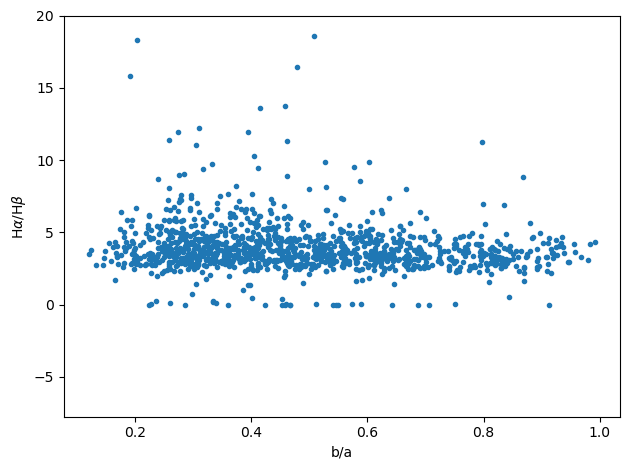

In [17]:
plt.figure(tight_layout=True)

plt.plot(gals['BA'], gals['HALPHA_FLUX']/gals['HBETA_FLUX'], '.')

plt.ylim(ymax=20)

plt.xlabel('b/a')
plt.ylabel(r'H$\alpha$/H$\beta$');

## 2. Compute $E(B-V)$ value for each galaxy

$A_\lambda / A_V$ from [O'Donnell (1994)](https://ui.adsabs.harvard.edu/abs/1994ApJ...422..158O/abstract)

In [7]:
def ODon94(wave, Rv):
    '''
    Calculate the interstellar extinction, A(lambda)/Av, using the extinction curve defined in O'Donnell (1994).
    
    
    PARAMETERS
    ==========
    
    wave : float
        Wavelength for which the extinction should be calculated.  Units are Angstroms.
        
    Rv : float
        Extinction ratio
        
        
    RETURNS
    =======
    
    AwAv : float
        The interstellar extinction for the given wavelength.
    '''
    
    # Convert wavelength to microns
    wave_um = wave/1e4
    
    # Calculate inverse wavelength
    x = 1/wave_um
    
    # Calculate wavelength shift
    y = x - 1.82
    
    # Calculate coefficients
    a = 1 + 0.104*y - 0.609*y**2 + 0.701*y**3 + 1.137*y**4 - 1.718*y**5 - 0.827*y**6 + 1.647*y**7 - 0.505*y**8
    b = 1.952*y + 2.908*y**2 - 3.989*y**3 - 7.985*y**4 + 11.102*y**5 + 5.491*y**6 - 10.805*y**7 + 3.347*y**8
    
    print(a, b)
    
    # Calculate extinction
    AwAv = a + b/Rv
    
    return AwAv

In [ ]:
gals['EBV'] = np.nan
gals['EBV_ERR'] = np.nan

AHaAv = ODon94(6563, Rv)
AHbAv = ODon94(4861, Rv)

gals['EBV'] = 2.5*np.log10(2.86/HaHb)/(Rv*(AHaAv - AHbAv))

## 3. Compute dust extinction correction

\begin{equation}
  A_\text{dust} = R_r E(B - V)
\end{equation}

In [ ]:
gals['Adust'] = Rr * gals['EBV']
gals['Adust_err'] = Rr * gals['EBV_ERR']

In [ ]:
plt.figure(tight_layout=True)

plt.hist(gals['Adust'], bins=np.arange(-0.1, 0.15, 0.005))

plt.xlabel(r'$A_\text{dust}$ [mag]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14);

# plt.savefig('../Figures/SV/fuji_Adust_hist_20240701.png', dpi=150);

## 4. Apply dust correction

In [ ]:
if 'R_MAG_SB26_CORR' not in gals.colnames:    
    gals['R_MAG_SB26_CORR'] = gals['R_MAG_SB26']
    gals['R_MAG_SB26_CORR_ERR'] = gals['R_MAG_SB26_ERR']

# Only adjust those galaxies which have valid corrections
nan_gal = np.isnan(gals['Adust'])
    
gals['R_MAG_SB26_CORR'][~nan_gal] -= gals['Adust'][~nan_gal]
gals['R_MAG_SB26_CORR_ERR'][~nan_gal] = np.sqrt(gals['R_MAG_SB26_CORR_ERR'][~nan_gal]**2 + gals['Adust_err'][~nan_gal]**2)